In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

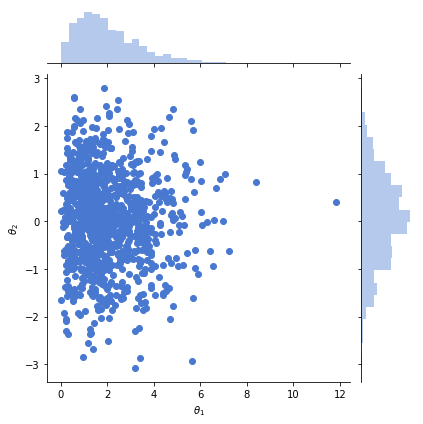

In [2]:
np.random.seed(123)
x = np.random.gamma(2, 1, 1000)
y = np.random.normal(0, 1, 1000)
data = pd.DataFrame(data=np.array([x, y]).T, columns=['$\\theta_1$', '$\\theta_2$'])
sns.jointplot(x='$\\theta_1$', y='$\\theta_2$', data=data, stat_func=None);

# Gaussian inferences

In [3]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

# remove outliers using the interquartile rule
quant = np.percentile(data, [25, 75])
iqr = quant[1] - quant[0]
upper_b = quant[1] + iqr * 1.5
lower_b = quant[0] - iqr * 1.5
clean_data = data[(data > lower_b) & (data < upper_b)]

Text(0.5, 0, '$x$')

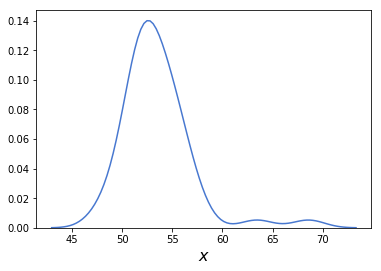

In [4]:
sns.kdeplot(data)
plt.xlabel('$x$', fontsize=16)

In [5]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', lower=40, upper=70)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data)
    trace_g = pm.sample(1100, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████| 1600/1600 [00:00<00:00, 2131.76it/s]


### Note that the traces of each variable are the marginal distributions not the real posterior which is a 2-dimensionsl joint distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f909da45dd8>,
      dtype=object)

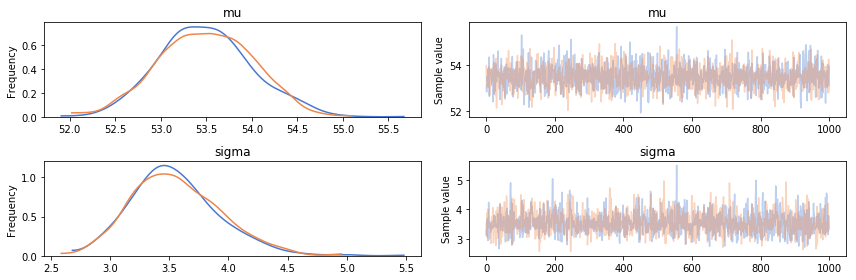

In [6]:
chain_g = trace_g[100:]
pm.traceplot(chain_g)

In [7]:
pm.summary(chain_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.49,0.51,9.89e-03,52.51,54.47,2059.13,1.0
sigma,3.55,0.37,9.39e-03,2.87,4.28,1707.96,1.0


/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 100/100 [00:00<00:00, 1442.89it/s]


Text(0.5, 0, '$x$')

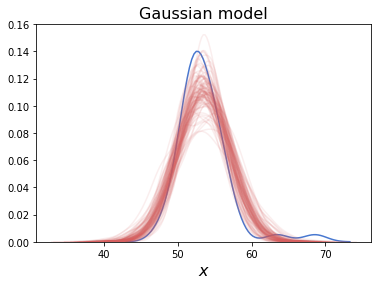

In [8]:
y_pred = pm.sample_ppc(chain_g, 100, model_g, size=len(data))
sns.kdeplot(data, color='b')
for i in y_pred['y']:
    sns.kdeplot(i.flatten(), color='r', alpha=0.1)
plt.title('Gaussian model', fontsize=16)
plt.xlabel('$x$', fontsize=16)

## Gaussian Robust inferences

Now we are going to learn how to make a robust model to outliers, that is a model that do not get too much excited by outliers. For that we are going to use a Student T distribution which can have heavier tails and allows for the presence of outliers

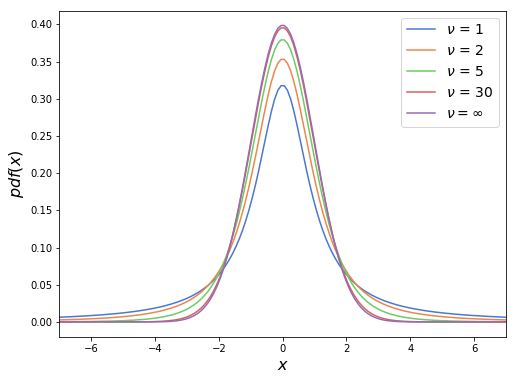

In [9]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 200)
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=r'$\nu$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label=r'$\nu = \infty$')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$pdf(x)$', fontsize=16, rotation=90)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);

In [10]:
with pm.Model() as model_t:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sd=10)
    nu = pm.Exponential('nu', 1/30)
    y = pm.StudentT('y', mu=mu, sd=sigma, nu=nu, observed=data)
    trace_t = pm.sample(11000,njobs=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [nu, sigma, mu]
Sampling 8 chains: 100%|██████████| 92000/92000 [00:21<00:00, 4206.86draws/s]


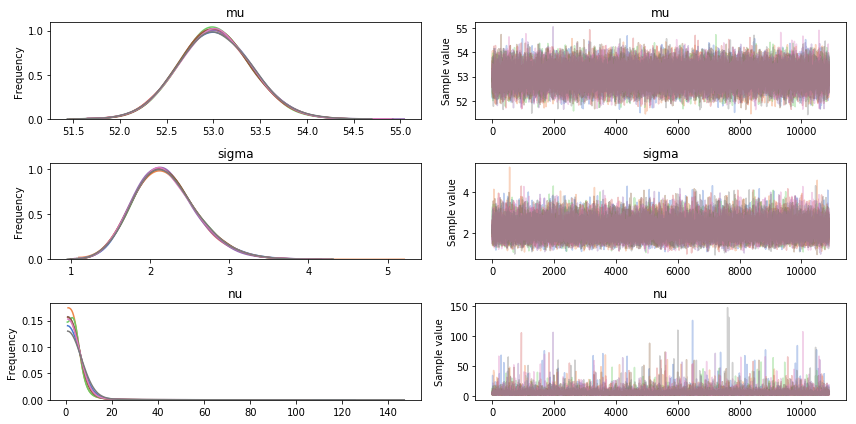

In [11]:
chain_t = trace_t[100:]
pm.traceplot(chain_t);

In [12]:
pm.summary(chain_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,53.01,0.39,1.71e-03,52.24,53.76,59098.57,1.0
sigma,2.19,0.40,2.07e-03,1.45,3.00,41200.08,1.0
nu,4.63,4.14,2.62e-02,1.15,10.18,28619.67,1.0


#### we can see that $\nu$~4 which indicates heavier tails than the normal when $\nu$->inf

/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 100/100 [00:00<00:00, 1081.86it/s]
/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


Text(0.5, 0, '$x$')

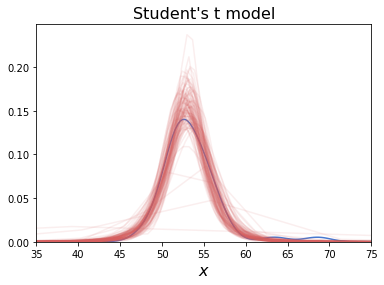

In [13]:
y_pred = pm.sample_ppc(chain_t, 100, model_t, size=len(data))
sns.kdeplot(data, c='b')
for i in y_pred['y']:
    sns.kdeplot(i.flatten(), c='r', alpha=0.1)
plt.xlim(35, 75)
plt.title("Student's t model", fontsize=16)
plt.xlabel('$x$', fontsize=16)

# Tips example

## we want to investigate the effect the day of the week has on the tips

In [14]:
tips = sns.load_dataset('tips')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


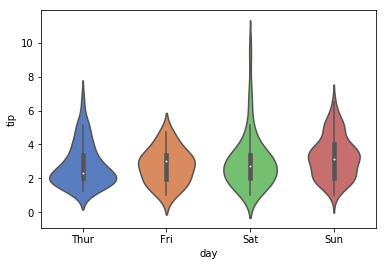

In [15]:
sns.violinplot(x='day', y='tip', data=tips);

In [16]:
y = tips['tip'].values
x = pd.Categorical(tips['day']).codes
categories = pd.Categorical(tips['day']).categories
print('Tips sample: {}'.format(y[:5]))
print('Encoded days sample: {}'.format(x[:5]))
print('Decoded days sample: {}'.format(categories[x[:5]]))

Tips sample: [1.01 1.66 3.5  3.31 3.61]
Encoded days sample: [3 3 3 3 3]
Decoded days sample: Index(['Sun', 'Sun', 'Sun', 'Sun', 'Sun'], dtype='object')


In [17]:
with pm.Model() as comparing_groups:    
    # priors
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(x)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(x)))
    # a different trace for each weekday as encoded in `x`
    y_pred = pm.Normal('y', mu=means[x], sd=sds[x], observed=y)    
    trace_cg = pm.sample(5000, chains=8, njobs=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sds, means]
Sampling 8 chains: 100%|██████████| 44000/44000 [00:21<00:00, 2066.64draws/s]


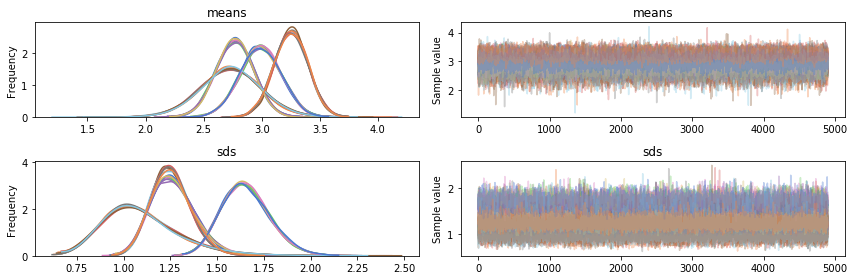

In [18]:
chain_cg = trace_cg[100::]
pm.traceplot(chain_cg);

In [19]:
pm.summary(chain_cg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
means__0,2.77,0.16,7.14e-04,2.46,3.09,44085.42,1.0
means__1,2.73,0.26,1.22e-03,2.22,3.24,39073.35,1.0
means__2,2.99,0.18,7.78e-04,2.65,3.34,43876.68,1.0
means__3,3.25,0.14,6.19e-04,2.98,3.54,43603.40,1.0
sds__0,1.27,0.12,5.50e-04,1.05,1.50,40396.75,1.0
sds__1,1.10,0.20,1.01e-03,0.75,1.50,35760.93,1.0
sds__2,1.66,0.13,5.63e-04,1.41,1.91,44519.30,1.0
sds__3,1.26,0.11,4.91e-04,1.06,1.47,40481.08,1.0


Comparison between the followin encoded days: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
Subplot indices: [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]


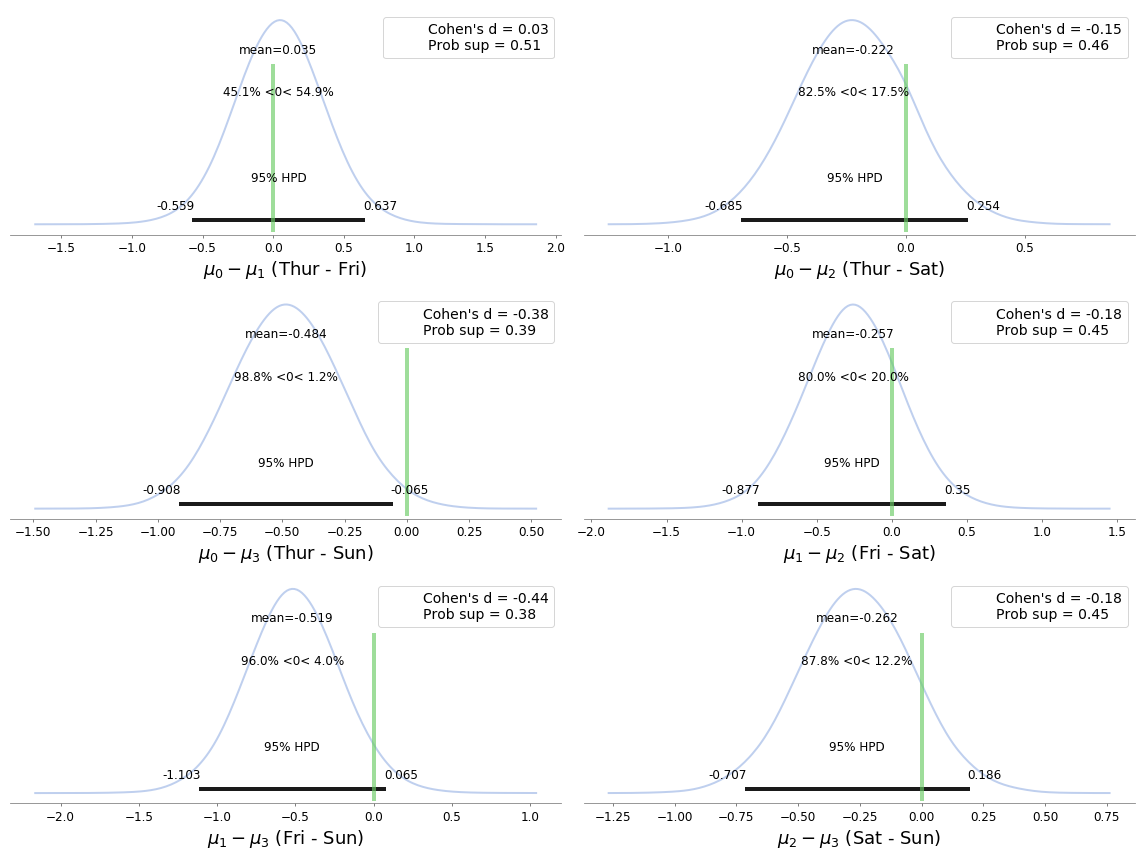

In [20]:
dist = dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(16, 12))

comparisons = [(i,j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0, 1)]

print('Comparison between the followin encoded days: {}'.format(comparisons))
print('Subplot indices: {}'.format(pos))
for (i, j), (k,l) in zip(comparisons, pos):
    # mean difference between days to be compared
    means_diff = chain_cg['means'][:,i]-chain_cg['means'][:,j]
    # effect size via Cohen's delta
    d_cohen = (means_diff / np.sqrt((chain_cg['sds'][:,i]**2 + chain_cg['sds'][:,j]**2) / 2)).mean()
    # probability of superiority
    ps = dist.cdf(d_cohen/(2**0.5))
        
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l], kde_plot=True, lw=2)
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps) ,alpha=0)
    ax[k, l].set_xlabel('$\mu_{}-\mu_{}$ ({} - {})'.format(i, j,categories[i],categories[j]), fontsize=18)
    ax[k,l ].legend(loc=0, fontsize=14)

    
plt.tight_layout()

### We can see that the only comparison where HPD95% excludes the reference values of zero is Thursday and Sunday. For the rest we cannot rule out a difference of zero. But the mean difference for Thursday - Sundsay is ~0.5, is this worth working weekends? Statisticians cannot answer these kind of questions

### For Cohen's delta see https://en.wikipedia.org/wiki/Effect_size#Cohen's_d 

### Probability of superiority $ps=\Phi(\frac{\delta}{\sqrt(2)})$ if we assume the group disrtibutions are Normal (not really used much)

# Hierarchical Models

In [21]:
N_samples =  [30, 30, 30]
# Number of good samples, i.e samples with lead content below WHO recommendations
G_samples =  [18, 3, 3] # [13, 3, 3] [18, 3, 3] [18, 18, 18]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []  
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))
print('Group id of each sample: {}'.format(group_idx))
print('Samples : (0->Bad, 1->Good) {}'.format(data))
print('Total number of samples = {}'.format(len(data)))

Group id of each sample: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Samples : (0->Bad, 1->Good) [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total number of samples = 90


$$\alpha \sim HalfCauchy(\beta_{\alpha})$$
$$\beta \sim HalfCauchy(\beta_{\beta})$$
$$\theta \sim Beta(\alpha, \beta)$$
$$y \sim Bern(\theta)$$

In [22]:
with pm.Model() as model_h:
    # hyper-priors
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)
    # prior
    theta = pm.Beta('theta', alpha, beta, shape=len(N_samples))
    # likelihood
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)

    trace_h = pm.sample(8000,njobs=8,chains=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [theta, beta, alpha]
Sampling 8 chains: 100%|██████████| 68000/68000 [00:24<00:00, 2787.89draws/s]
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9083733208>,
      dtype=object)

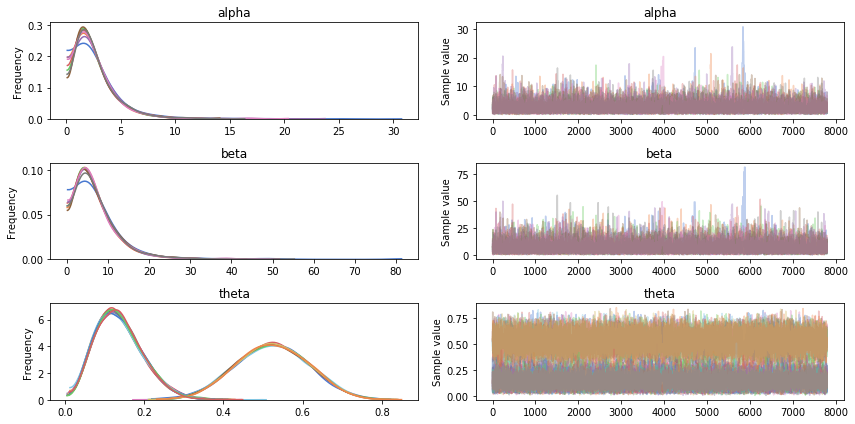

In [23]:
chain_h = trace_h[200:]
pm.traceplot(chain_h)

In [24]:
pm.summary(chain_h)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,2.66,2.08,2.95e-02,0.16,6.41,4278.79,1.0
beta,7.34,5.86,8.26e-02,0.31,17.83,4362.81,1.0
theta__0,0.52,0.09,5.41e-04,0.35,0.70,28992.11,1.0
theta__1,0.14,0.06,3.47e-04,0.03,0.26,32777.08,1.0
theta__2,0.14,0.06,3.03e-04,0.03,0.26,32472.88,1.0


(62400, 3)


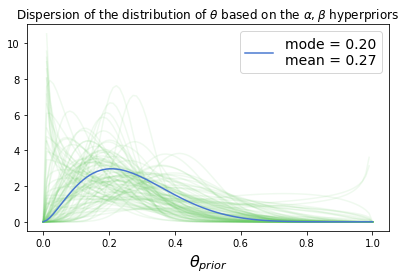

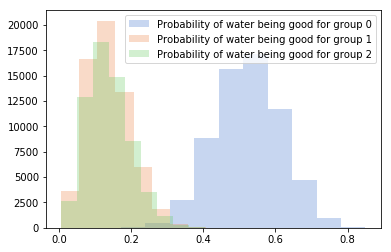

In [25]:
x = np.linspace(0, 1, 100)
print(chain_h['theta'].shape)

for i in np.random.randint(0, len(chain_h), size=100):
    pdf = stats.beta(chain_h['alpha'][i], chain_h['beta'][i]).pdf(x)
    plt.plot(x, pdf,  'g', alpha=0.1)

dist = stats.beta(chain_h['alpha'].mean(), chain_h['beta'].mean())
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))
plt.title(r'Dispersion of the distribution of $\theta$ based on the $\alpha, \beta$ hyperpriors')

plt.legend(fontsize=14)
plt.xlabel('$\\theta_{prior}$', fontsize=16)
plt.tight_layout()

plt.figure()
for i, thetaChain in enumerate(chain_h['theta'].T):
    plt.hist(thetaChain,alpha=0.3, label='Probability of water being good for group {}'.format(i))
plt.legend()

In [26]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running debian buster/sid and using:
Python 3.7.2
IPython 7.2.0
PyMC3 3.6
NumPy 1.16.0
SciPy 1.2.0
Matplotlib 3.0.2
Seaborn 0.9.0
Pandas 0.23.4


/home/damianos/miniconda3/envs/pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
